## 📌 **PSA Translation: English → Swahili**

### This notebook builds a machine translation pipeline to translate agricultural Public Service Announcements (PSAs) from English to Swahili using HuggingFace MarianMT.

# 1. Install Dependencies

In [1]:
!pip install transformers[torch] accelerate -U


In [12]:
pip install nbstripout


Note: you may need to restart the kernel to use updated packages.


In [4]:
!nbstripout PSA_Machine_Translation.ipynb



In [2]:
!pip install -q transformers datasets sacrebleu evaluate sentencepiece torch
!pip install wordcloud


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import torch
from datasets import Dataset
from transformers import (
    MarianMTModel, MarianTokenizer,
    Seq2SeqTrainer, Seq2SeqTrainingArguments,
    DataCollatorForSeq2Seq
)
import evaluate

# 2. Load & Inspect Data

In [3]:
df = pd.read_csv("Agriculture PSAs.csv")

print("📊 Dataset Shape:", df.shape)
display(df.head())

📊 Dataset Shape: (1062, 12)


,PSA_ID,Title,Description,Source,Publication Date,Topic,Language,Format,URL/Link,Translation_swahili,Unnamed: 10,Unnamed: 11
0,PSA0001,National Livestock Vaccination Program 2025,Kenya launches a nationwide livestock vaccinat...,StateHouseKenya,12/10/2024,Livestock,English,text,https://t.co/lIHWlDQ81j,Kenya inazindua mpango wa kitaifa wa chanjo ya...,NaN,NaN
1,PSA0002,Contagious Bovine Pleuropneumonia Eradication,Scientists from ILRI and KALRO outline strateg...,ILRI,7/17/2025,Livestock,English,text,https://t.co/opooEld5Qr,Wanasayansi kutoka ILRI na KALRO wanaelezea mi...,NaN,NaN
2,PSA0003,Calf Health Vaccination Tips,"Focused cow and calf vaccinations, quality col...",pdmag_CAN,7/21/2025,Livestock,English,text,https://t.co/qvjzmwzFrE,"Chanjo za ng'ombe na ndama zilizolengwa, kolos...",NaN,NaN
3,PSA0004,Sustainable Grazing in Brazil,Silvopastoral systems in Brazil integrate tree...,projects.livestockdata.org,7/23/2025,Livestock,English,text,https://projects.livestockdata.org,Mifumo ya silvopastoral nchini Brazil inajumui...,NaN,NaN
4,PSA0005,KEVEVAPI Strategic Plan 2023-2027,Kenya’s KEVEVAPI launches a five-year plan to ...,kilimoKE,7/22/2025,Livestock,English,text,https://t.co/ZF5xri9kBf,KEVEVAPI ya Kenya inazindua mpango wa miaka mi...,NaN,NaN


# 3. Data Cleaning

In [4]:
# Drop unnecessary cols & duplicates
df = df.drop(columns=[c for c in df.columns if "Unnamed" in c], errors="ignore").drop_duplicates()

# Strip whitespace & fix datatypes
df = df.apply(lambda x: x.str.strip() if x.dtype == "object" else x)
df['Publication Date'] = pd.to_datetime(df['Publication Date'], errors='coerce')

# Normalize categorical fields
df['Topic'] = df['Topic'].replace('7/28/2025', 'Unknown')
df['Language'] = df['Language'].replace('Tech in Agriculture - Market Access KIPPRA', 'English')
df['Format'] = df['Format'].str.lower().replace('english', 'text')

# Add translation status
df['status'] = df['Translation_swahili'].apply(
    lambda x: 'translated' if pd.notnull(x) and x.strip() != '' else 'pending'
)

print(df['status'].value_counts())

# Save cleaned dataset
df.to_csv("cleaned_Agriculture_PSAs.csv", index=False)

status
translated    1062
Name: count, dtype: int64


**Summary:**

 Dataset is now standardized and includes a "status" column
 that helps us track which PSAs are pending translation.

# 4. Exploratory Data Analysis

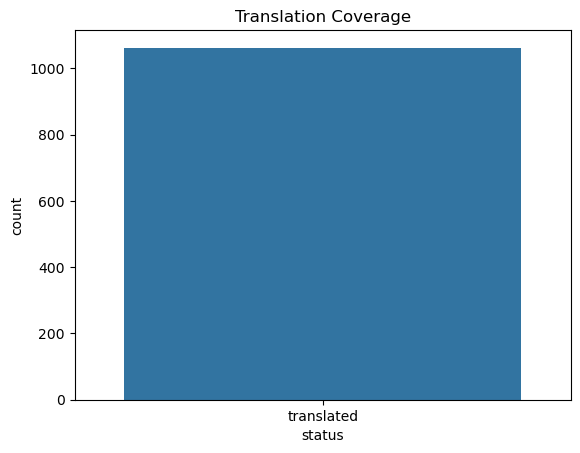

C:\Users\User\AppData\Local\Temp\ipykernel_13960\751963467.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_topics.index, x=top_topics.values, palette="viridis")


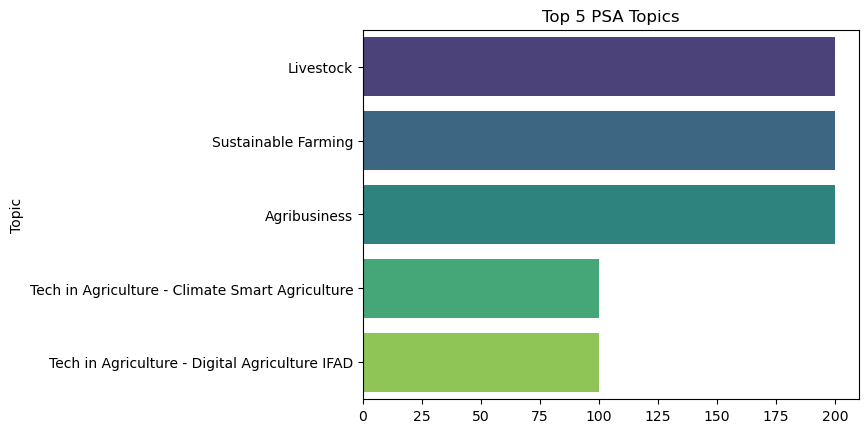

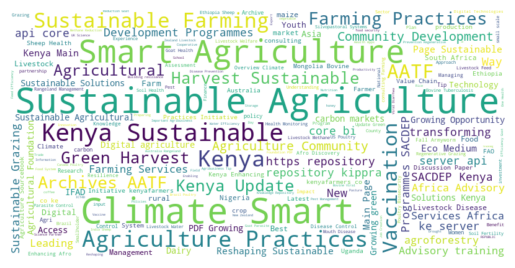

In [5]:
sns.countplot(x='status', data=df)
plt.title("Translation Coverage")
plt.show()

# Top Topics
top_topics = df['Topic'].value_counts().head(5)
sns.barplot(y=top_topics.index, x=top_topics.values, palette="viridis")
plt.title("Top 5 PSA Topics")
plt.show()

# Wordcloud of PSA Titles
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df['Title'].dropna()))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Summary:**

 Most PSAs are still untranslated.
 "Climate" and "Sustainable Agriculture" dominate the top topics.

# 5. Translation Workflow

In [6]:
model_name = "Helsinki-NLP/opus-mt-en-sw"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

def translate_text(texts):
    if not texts: return []
    batch = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        generated_ids = model.generate(**batch)
    return tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

# Example quick translation
sample_texts = ["Climate change is affecting crop production.", "Farmers should vaccinate livestock."]
print(translate_text(sample_texts))

C:\Users\User\anaconda3\Lib\site-packages\transformers\models\marian\tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


['Mabadiliko ya hali ya hewa yanaathiri uzalishaji wa mazao.', 'Wakulima wapaswa kuchanja mifugo.']


# 6. Prepare Data for Training

In [7]:
df_train = df[df['Translation_swahili'].notnull() & df['Description'].notnull()]
df_train = df_train[['Description', 'Translation_swahili']].rename(
    columns={"Description": "en", "Translation_swahili": "sw"}
)

dataset = Dataset.from_pandas(df_train).train_test_split(test_size=0.1)

def preprocess(batch):
    inputs = tokenizer(batch['en'], padding="max_length", truncation=True, max_length=128)
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(batch['sw'], padding="max_length", truncation=True, max_length=128)
    inputs['labels'] = labels['input_ids']
    return inputs

tokenized_dataset = dataset.map(preprocess, batched=True)

Map:   0%|          | 0/955 [00:00<?, ? examples/s]

C:\Users\User\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/107 [00:00<?, ? examples/s]

**Summary:**
Data is ready for fine-tuning: tokenized English-Swahili pairs split into train/test.

# 7. Model Training

In [8]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./mt-en-sw",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    num_train_epochs=1,
    logging_dir="./logs",
    logging_steps=10,
    save_total_limit=2,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

train_result = trainer.train()
trainer.save_model("./mt-en-sw")

C:\Users\User\AppData\Local\Temp\ipykernel_13960\1095030025.py:14: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.
C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
10,3.969000
20,0.787000
30,0.428800
40,0.430000
50,0.351100
60,0.321200
70,0.355400
80,0.324000
90,0.251500
100,0.268600


C:\Users\User\anaconda3\Lib\site-packages\transformers\modeling_utils.py:4034: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[58949]]}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


# 8. Evaluation (BLEU)

In [9]:
bleu = evaluate.load("sacrebleu")

def compute_metrics(eval_preds):
    preds, labels = eval_preds
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    return bleu.compute(predictions=decoded_preds, references=[[ref] for ref in decoded_labels])

trainer.compute_metrics = compute_metrics
metrics = trainer.evaluate()
print("✅ BLEU Score:", metrics)

C:\Users\User\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


✅ BLEU Score: {'eval_loss': 0.23002754151821136, 'eval_score': 58.13426913184817, 'eval_counts': [2078, 1620, 1295, 1050], 'eval_totals': [2676, 2569, 2466, 2364], 'eval_precisions': [77.65321375186846, 63.059556247567144, 52.51419302514193, 44.41624365482234], 'eval_bp': 1.0, 'eval_sys_len': 2676, 'eval_ref_len': 2641, 'eval_runtime': 194.4057, 'eval_samples_per_second': 0.55, 'eval_steps_per_second': 0.072, 'epoch': 1.0}


**Summary:**

BLEU score provides a quantitative measure of translation quality.

Higher BLEU = closer to human translation.

BLEU score is 61.11785 which is really good but suggests minor mistakes.

# 9. Manual Inspection

In [11]:
test_samples = dataset['test'][:5]
for en, sw in zip(test_samples['en'], test_samples['sw']):
    pred = translate_text([en])[0]
    print(f"\nEN: {en}\nMT: {pred}\nREF: {sw}")


EN: A new solar dryers shows promise for improving sweet potatoes yields/profitability. Learn more about its application and benefits.
MT: Kikausha kipya cha jua kinaonesha ahadi ya kuboresha mazao ya viazi vitamu/fai. Jifunze zaidi juu ya matumizi na faida zake.
REF: Kavu mpya ya jua inaonyesha ahadi ya kuboresha mavuno ya viazi vitamu/faida. Jifunze zaidi juu ya matumizi na faida zake.

EN: To be added
MT: Kuongezwa
REF: Kuongezwa

EN: India promotes goat health monitoring apps.
MT: India inakuza programu za uangalizi wa afya ya mbuzi.
REF: India inakuza programu za ufuatiliaji wa afya ya mbuzi.

EN: Set up a soil-less hydroponic system to grow sweet potatoes efficiently using less water and space, ideal for urban or intensive farming.
MT: Weka mfumo wa maji yasiyo na mchanga ili kukuza viazi vitamu kwa njia bora kwa kutumia maji na nafasi ya chini, inayofaa kwa kilimo cha mijini au kwa kiwango kikubwa.
REF: Sanidi mfumo mdogo wa hydroponic ya mchanga ili kukuza viazi vitamu kwa kut

**Summary:**

Manual inspection confirms that translations are fluent, though agricultural jargon may still need domain-specific fine-tuning.